# Cookie Cats - A/B Testing

### Introduction

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It follows the classic "connect three" puzzle format, \
where players must connect tiles of the same color to clear the board and complete levels. \
One of the game’s unique features is its charming cast of singing cats.

In this project, we conduct and analyze an **A/B test** to assess the impact of moving the \
first gate in the game from **level 30** to **level 40**. The gate is a mechanism that requires players to wait for a certain time \
or make an in-app purchase to progress to the next level. The primary focus of the analysis is to evaluate the impact of this change on player retention and engaging.



In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
from scipy.stats import shapiro, levene
from scipy.stats import chisquare
from scipy.stats import mannwhitneyu
from statsmodels.stats import proportion
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'Times New Roman'

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
size=20
params = {'legend.fontsize': 'large',
        'figure.figsize': (12,8),
        'axes.labelsize': size,
        'axes.titlesize': size,
        'xtick.labelsize': size*0.75,
        'ytick.labelsize': size*0.75,
        'axes.titlepad': 25}
plt.rcParams.update(params)

In [13]:
dataset = pd.read_csv('./cookie_cats.csv')
dataset.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


**Column explanation**: 
 
1. **userid** is unique identifier for each player in the dataset.

2. **version** describes whether the player was in the control group or the test group.
    - **gate_30**: Players in the control group with a gate at level 30.
    - **gate_40**: Players in the test group with a gate at level 40. 
<br/><br/>
3. **sum_gamerounds** is the number of game rounds played by the player during the first 14 days after install.

4. **Retention_1** and **Retention_7** signify whether the player returned to play the game one day or seven days after installation, respectively.

    - **True**: The player returned.
    - **False**: The player did not return.

In [14]:
print("Total number of players: ", len(dataset['userid'].unique()))

Total number of players:  90189


In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [16]:
if dataset.isna().sum().any():
    print('There are missing values in the dataset')
else:
    print('There are no missing values in the dataset')

if dataset.duplicated().any():
    print('There are duplicated values in the dataset')
else:
    print('There are no duplicated values in the dataset')


There are no missing values in the dataset
There are no duplicated values in the dataset


### Exploratory Data Analysis

In [17]:
# Convert version column to group A and B
dataset.rename(columns={"version": "group"},inplace=True)
dataset["group"] = np.where(dataset.group == "gate_30", "A", "B")
dataset.loc[:,"group"]=dataset.group.astype("category")
dataset.head()

,userid,group,sum_gamerounds,retention_1,retention_7
0,116,A,3,False,False
1,337,A,38,True,False
2,377,B,165,True,False
3,483,B,1,False,False
4,488,B,179,True,True


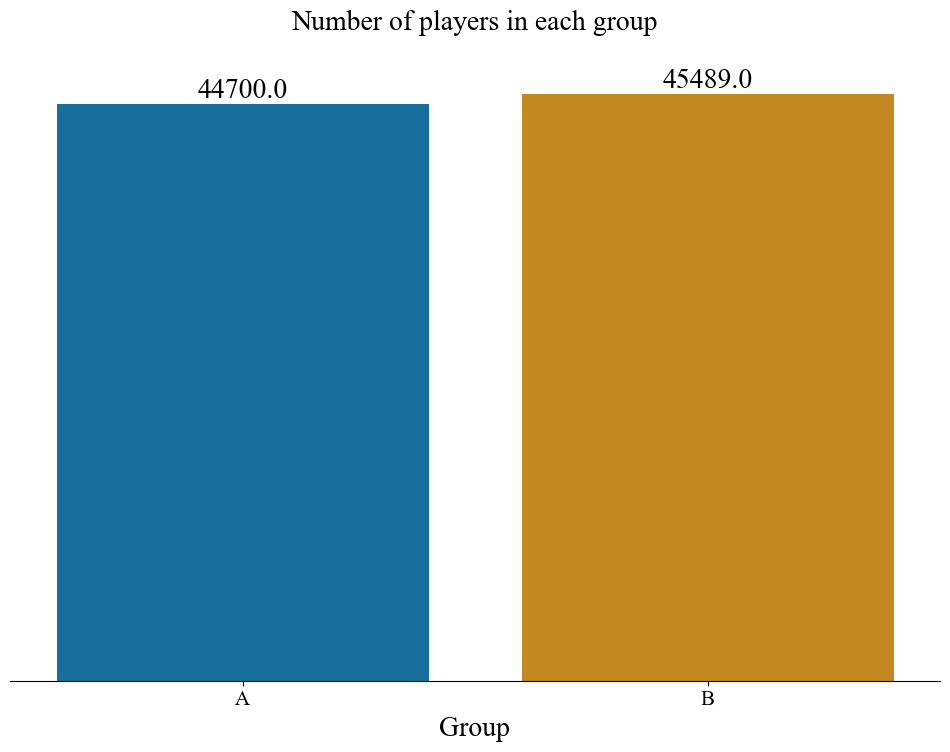

In [18]:
fig, ax = plt.subplots()
sns.countplot(x='group', data=dataset, palette='colorblind')
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height() + 0.5, str(i.get_height()), ha='center', va='bottom', fontsize=20)
ax.set_title('Number of players in each group')
ax.set_xlabel('Group')
ax.set_ylabel('')
ax.set_yticks([])
ax.spines[['right','top', 'left']].set_visible(False)
plt.show()

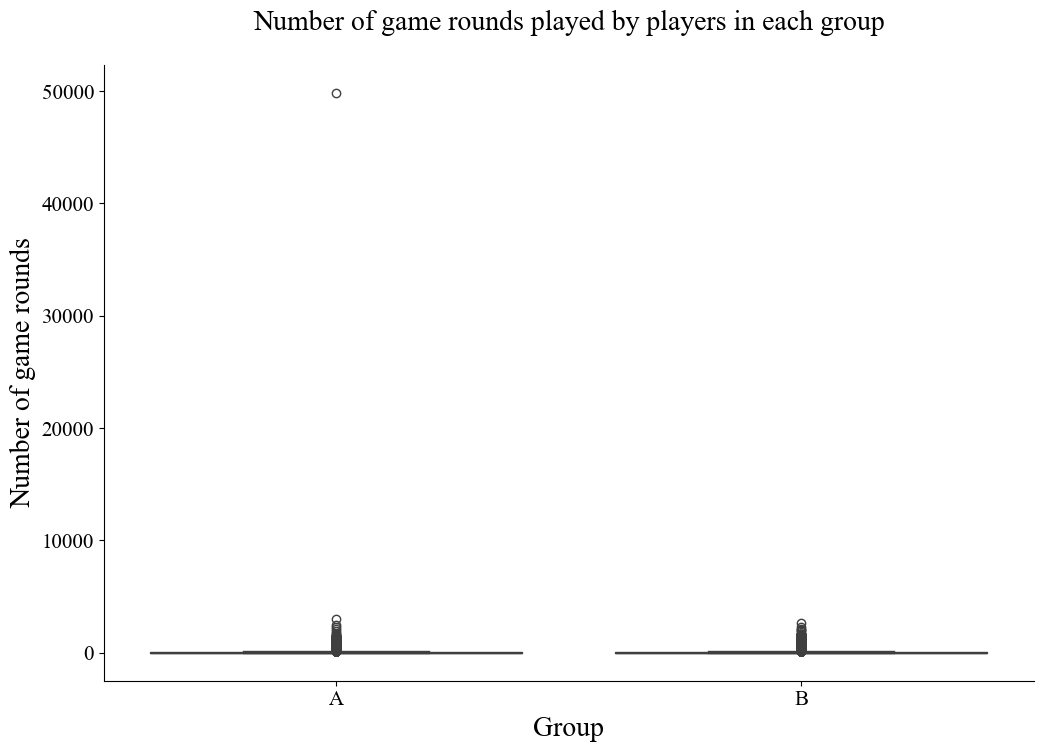

In [19]:
fig, ax = plt.subplots()
sns.boxplot(x='group', y='sum_gamerounds', data=dataset)
ax.set_title('Number of game rounds played by players in each group')
ax.set_xlabel('Group')
ax.set_ylabel('Number of game rounds')
ax.spines[['right','top']].set_visible(False)
plt.show()

In [20]:
print(f"There is an outlier: {dataset['sum_gamerounds'].max()} in group A")

There is an outlier: 49854 in group A


In [21]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_cleaned = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df_cleaned

dataset = remove_outliers(dataset, 'sum_gamerounds')

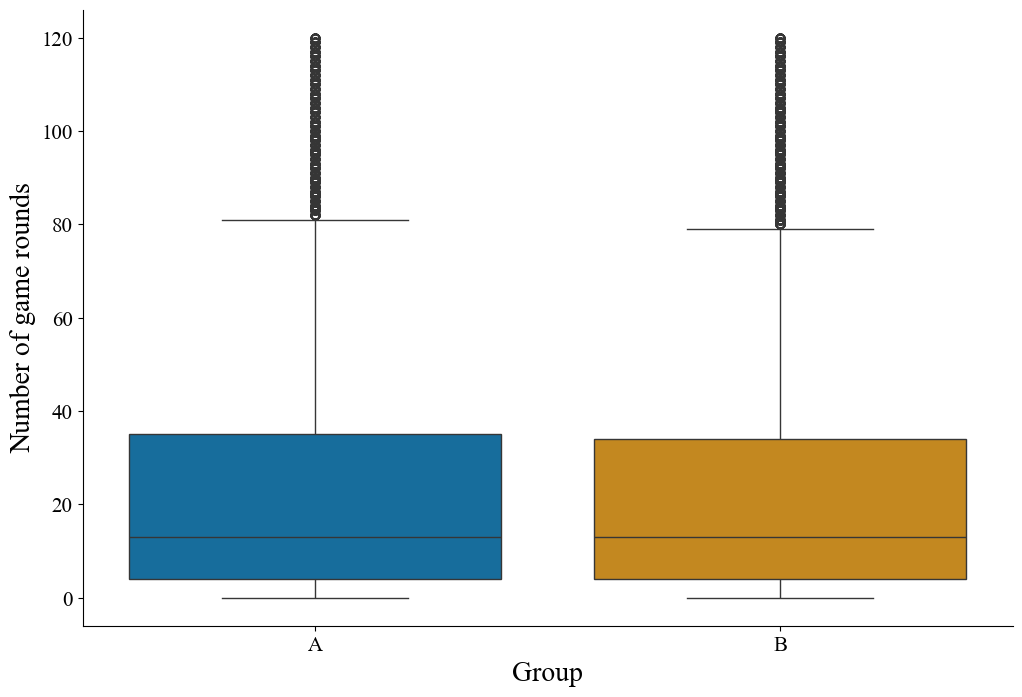

In [22]:
fig, ax = plt.subplots()
sns.boxplot(data=dataset, x="group", y="sum_gamerounds", palette='colorblind')
ax.set_ylabel('Number of game rounds')
ax.set_xlabel('Group')
ax.spines[['right','top']].set_visible(False)
plt.show()

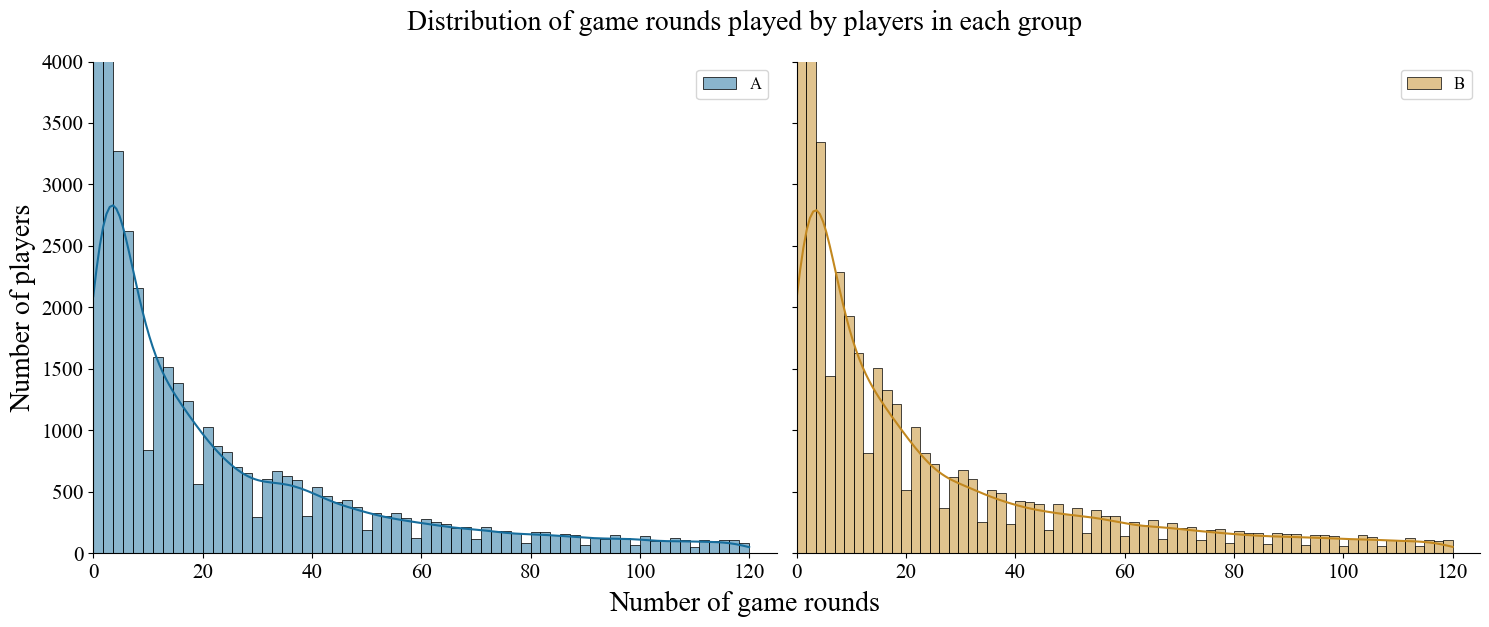

In [23]:
fig, ax = plt.subplots(1,2, figsize=(15,6), sharey=True)
sns.histplot(data=dataset[dataset['group'] == 'A'], x='sum_gamerounds', kde=True, ax=ax[0], color='#166d9c', label='A')
ax[0].set_ylabel('Number of players')

sns.histplot(data=dataset[dataset['group'] == 'B'], x='sum_gamerounds', kde=True, ax=ax[1], color='#c3881f', label='B')

plt.suptitle('Distribution of game rounds played by players in each group', fontsize=20)
fig.text(0.5, -0.01, 'Number of game rounds', ha='center', va='center', fontsize=20)
for i in range(2):
    ax[i].spines[['right','top']].set_visible(False)
    ax[i].set_xlim(0, 125)
    ax[i].set_ylim(0, 4000)
    ax[i].set_xlabel('')
    ax[i].legend(loc='upper right')
plt.tight_layout()
plt.show()


In [24]:
# Percentage of players in control and treatment groups

treatment, control = dataset['group'].value_counts()[0], dataset['group'].value_counts()[1]
print(f'{control / dataset.shape[0] * 100:.2f}% of users in control group (A)')
print(f'{treatment / dataset.shape[0] * 100:.2f}% of users in treatment group (B)')

49.54% of users in control group (A)
50.46% of users in treatment group (B)


####  Sample Ratio Mismatch (SRM)

Sample Ratio Mismatch (SRM) occurs when the observed sample ratio differs significantly from the expected sample ratio in an A/B test.

For example, in an A/B test designed with a 50/50 split, the expected ratio between the control and test groups is 1:1.\
However, if the observed split is 40/60, the ratio deviates substantially from the expected value, resulting in an SRM.

In [25]:
def SRMcheck(dataset):
    num_A = dataset["group"].value_counts().loc["A"]
    num_B = dataset["group"].value_counts().loc["B"]

    print('Expected number of players in each group:', len(dataset)/2)
    print("Number of players in group A (gate_30):",num_A)
    print("Number of players in group B (gate_40):",num_B)
    print("A/B ratio: {:.5f}".format(num_A/num_B))
    print("-"*45)
    
    observed = [ num_A, num_B ]
    total_player= sum(observed)
    expected = [ total_player/2, total_player/2 ]

    chi, pvalue = chisquare(observed, f_exp=expected)
    print("pvalue: {:.3f}".format(pvalue))
    print("*"*15)
    if pvalue < 0.01:
        print('SRM may be present.')
    else:
        print('Probably no SRM.')

In [26]:
SRMcheck(dataset)

Expected number of players in each group: 40006.0
Number of players in group A (gate_30): 39638
Number of players in group B (gate_40): 40374
A/B ratio: 0.98177
---------------------------------------------
pvalue: 0.009
***************
SRM may be present.


**Results Interpretation**

- The **A/B ratio** of 0.98177 suggests a **slight imbalance between the two groups**, with Group B having slightly more users than Group A. While a small imbalance may not drastically affect the results, it could introduce bias into the analysis.

- The significant **p-value** (0.009) indicates that the imbalance between the groups is **unlikely to be due to random chance**.

- Therefore, we **reject the null hypothesis** that the observed A/B ratio is consistent with the expected ratio. This indicates that the observed **mismatch is statistically significant**, and there is likely an issue with how the samples were split or collected.

___

**Addressing Sample Ratio Mismatch (SRM)**

In the presence of SRM (e.g., A/B ratio $\neq$ 1), the imbalance between groups can lead to biased estimates and incorrect confidence intervals if standard parametric methods (like a t-test) are applied without adjustment.

To address this, we use **Bootstrap Analysis**, which provides a robust approach for estimating confidence intervals and validating results under imbalanced conditions:

- **Reflecting Real-World Conditions**: \
Bootstrapping creates multiple resampled datasets that replicate the observed imbalance, ensuring the analysis mimics the real-world situation.

- **Estimating Confidence Intervals**: \
It allows us to compute confidence intervals for key metrics (e.g., retention rates, total rounds played) without assuming equal sample sizes between groups.

- **Validating Statistical Significance**:
Bootstrapping helps evaluate whether differences between groups are statistically significant, even in the presence of an uneven sample distribution.

>**Key Note**
>
>However, the small difference in the A/B ratio suggests that this issue may not be significant enough to pose a problem. To confirm this, in addition to the Bootstrap Analysis, we will perform the appropriate statistical tests to rigorously evaluate the significance of the observed differences. 

### 1 Statistical Test to Compare Groups

The primary goal of this analysis is to evaluate whether the placement of the progression gate significantly \
impacts player retention and engagement. Therefore, we'll consider three separate targets: `retention_1`, \
`retention_7`, and `sum_gamerounds`. 

Specifically, the analysis focuses on two key objectives:

- **Retention**

Does placing the gate at level 40 (**gate_40**) result in higher 1-day and 7-day retention rates compared to placing it at level 30 (**gate_30**)?

- **Engagement**

Does the gate placement influence the total number of game rounds played (**sum_gamerounds**) within the first 14 days?


##### 1.1 Retention rate after 1 and 7 days.


**Establish the Hypotheses**
- **Null Hypothesis (H<sub>0</sub>)**: _M<sub>1</sub> = M<sub>2</sub>_ \
There is no statistical difference between **gate_30** and **gate_40**.

- **Alternative Hypothesis (H<sub>1</sub>)**: _M<sub>1</sub> $\neq$ M<sub>2</sub>_ \
There is a statistical difference between **gate_30** and **gate_40**.

##### 1.1.1 Bootstrap

1-day retention mean difference: 0.0055
1-day retention 95% CI: [-0.0011, 0.0118]
7-day retention mean difference: 0.0084
7-day retention 95% CI: [0.0039, 0.0129]


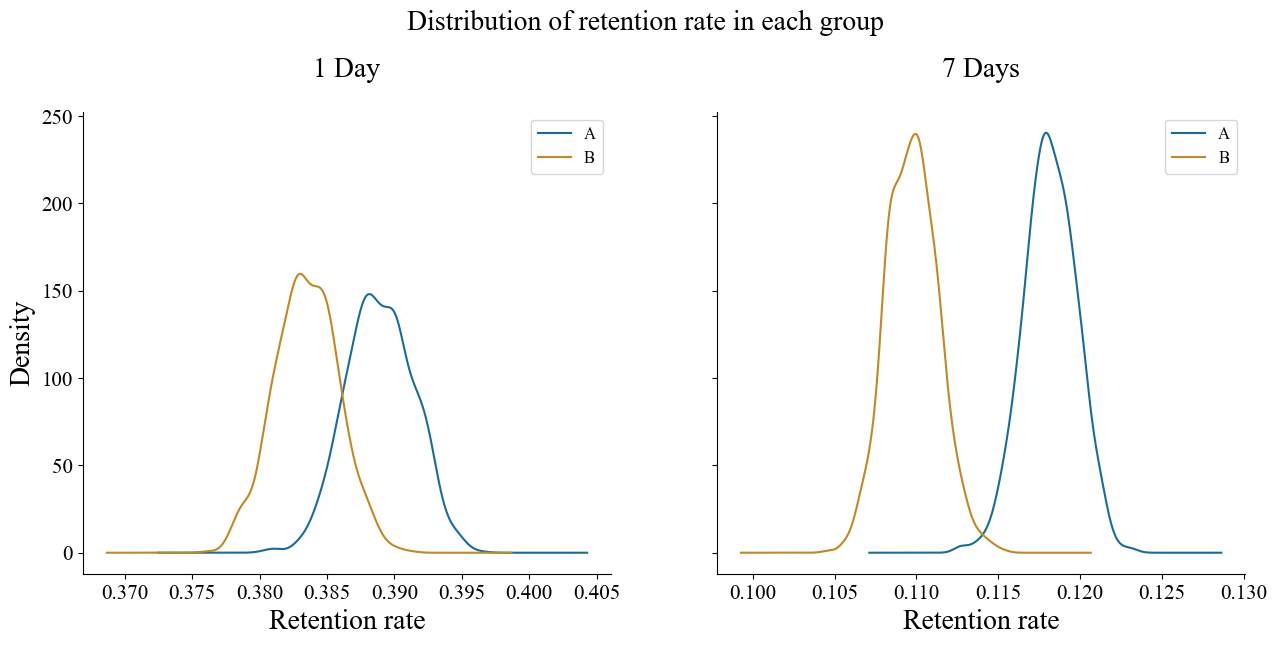

In [27]:
# Compute bootstrap samples
bootstrap_1d = pd.DataFrame([dataset.sample(frac=1, replace=True).groupby("group")["retention_1"].mean() for i in range(1000)])
bootstrap_7d = pd.DataFrame([dataset.sample(frac=1, replace=True).groupby("group")["retention_7"].mean() for i in range(1000)])

# Compute mean differences
mean_diff_1d = bootstrap_1d['A'] - bootstrap_1d['B']
mean_diff_7d = bootstrap_7d['A'] - bootstrap_7d['B']

# Calculate 95% confidence intervals
ci_1d = np.percentile(mean_diff_1d, [2.5, 97.5])
ci_7d = np.percentile(mean_diff_7d, [2.5, 97.5])

# Print results
print(f"1-day retention mean difference: {mean_diff_1d.mean():.4f}")
print(f"1-day retention 95% CI: [{ci_1d[0]:.4f}, {ci_1d[1]:.4f}]")
print(f"7-day retention mean difference: {mean_diff_7d.mean():.4f}")
print(f"7-day retention 95% CI: [{ci_7d[0]:.4f}, {ci_7d[1]:.4f}]")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

bootstrap_1d.plot.kde(ax=ax[0], color=['#166d9c', '#c3881f'])
bootstrap_7d.plot.kde(ax=ax[1], color=['#166d9c', '#c3881f'])

for i in range(2):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xlabel('Retention rate')
    ax[i].set_ylabel('Density')
    ax[i].legend(['A', 'B'])
    ax[i].set_title(f'{["1 Day", "7 Days"][i]}')

plt.suptitle('Distribution of retention rate in each group', fontsize=20, y=1.05)
plt.show()


**Results Based on Bootstrap Analysis**

- **1-Day Retention Rates**:
The mean difference in 1-day retention rates between Group B and Group A is 0.0055 (0.55 percentage points), with a 95% confidence interval of [-0.0011, 0.0118].

    - This indicates that the treatment in Group B **may slightly improve retention**, but the effect is **not statistically significant** because the confidence interval includes zero.

    - Furthermore, the small magnitude of the difference suggests that even if the effect were real, it might **lack practical significance**.
- **7-Day Retention Rates**:
The mean difference in 7-day retention rates between Group B and Group A is 0.0084 (0.84 percentage points), with a 95% confidence interval of [0.0039, 0.0129].

    - In this case, the confidence interval does not include zero, indicating that the treatment in Group B has a **statistically significant** positive effect on 7-day retention.
    
    - However, the **small magnitude of the difference** (less than 1 percentage point) suggests that the practical significance of this improvement should be **carefully assessed**, particularly in the context of business goals and user experience.

#### 1.1.2 Z-test

In [28]:
def perform_ztest(dataset, retention_col):
    x_retention = dataset.groupby('group')[retention_col].sum()
    num = dataset.groupby('group')[retention_col].count()
    count = x_retention.values
    nobs = num.values
    z_score, p_value = proportion.proportions_ztest(count, nobs)
    mean_diff = dataset.groupby('group')[retention_col].mean().diff().values[1]
    ci_low, ci_high = proportion.proportion_confint(count[1], nobs[1], alpha=0.05)
    return z_score, p_value, (ci_low, ci_high)

z_score_1, p_value_1, ci_1 = perform_ztest(dataset, 'retention_1')
z_score_7, p_value_7, ci_7 = perform_ztest(dataset, 'retention_7')

print(f"Results for day 1 retention rate: z_score = {z_score_1:.3f}, p_value = {p_value_1:.3f}, and CI = {ci_1}")
print(f"Results for day 7 retention rate: z_score = {z_score_7:.3f}, p_value = {p_value_7:.3f}, and CI = {ci_7}")

Results for day 1 retention rate: z_score = 1.665, p_value = 0.096, and CI = (0.3786229198804789, 0.3881081446660114)
Results for day 7 retention rate: z_score = 3.704, p_value = 0.000, and CI = (0.10674880976090315, 0.11284796043773954)


**Overall Conclusion for 1-Day Retention**

1. The **p-value** (0.096) is greater than the common significance threshold of 0.05, confirming that the difference is **not statistically significant**.

2. The **small mean difference** (0.59 percentage points) suggests that the Group B may have a **negligible effect** on 1-day retention.

There is **no statistically significant** evidence that placing the gate at level 40 (Group B) improves 1-day retention compared to placing it at level 30 (Group A). The observed difference is likely due to random variation.

**Overall Conclusion for 7-Day Retention**

1. The **p-value** (0.000) is much smaller than the common significance threshold of 0.05, confirming that the **difference is statistically significant**.

2. The positive **mean difference** (0.84 percentage points) suggests that the treatment (Group B) has a small but **significant positive effect** on 7-day retention.

There is **statistically significant** evidence that placing the gate at level 40 (Group B) improves 7-day retention compared to placing it at level 30 (Group A). However, the effect size is small, so the practical significance of this **improvement should be carefully evaluated**.

#### 1.2. Engagement

In [30]:
# Those who never played games probably had no effect on the experiment

dataset[dataset['sum_gamerounds'] == 0].groupby('group').size()
dataset=dataset[dataset.sum_gamerounds != 0].reset_index()

In [31]:
dataset.groupby("group").sum_gamerounds.agg(["sum","mean","median"])

,sum,mean,median
group,,,
A,949139,25.175433,15.0
B,969483,25.301642,14.0


#### 1.2.1 Bootstrap

The mean difference in game rounds played between the two groups is 0.0052
The 95% confidence interval is [-0.0018, 0.0123]


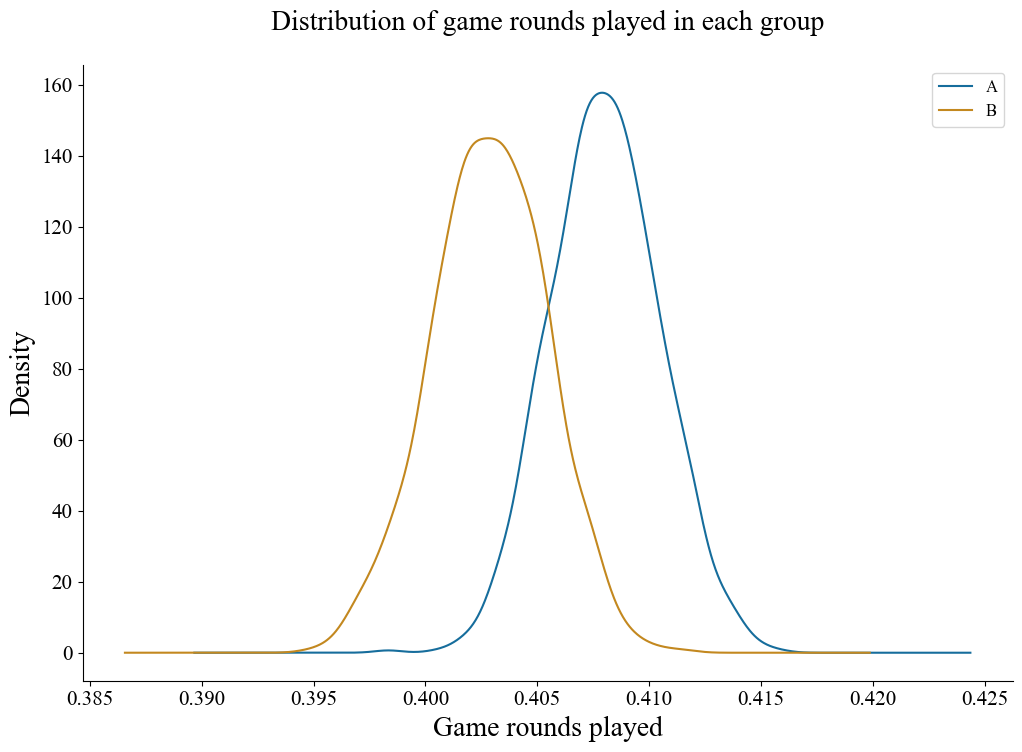

In [32]:
sum_gamerounds = pd.DataFrame([dataset.sample(frac=1, replace=True).groupby("group")["retention_1"].mean() for i in range(1000)])

# Compute mean differences
mean_diff = sum_gamerounds['A'] - sum_gamerounds['B']

# Calculate 95% confidence intervals
ci = np.percentile(mean_diff, [2.5, 97.5])

# Print results
print(f"The mean difference in game rounds played between the two groups is {mean_diff.mean():.4f}")
print(f"The 95% confidence interval is [{ci[0]:.4f}, {ci[1]:.4f}]")

# Plotting
fig, ax = plt.subplots()
sum_gamerounds.plot.kde(ax=ax, color=['#166d9c', '#c3881f'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Game rounds played')
ax.set_ylabel('Density')
ax.legend(['A', 'B'])
ax.set_title('Distribution of game rounds played in each group')
plt.show()


- The A/B test comparing gate placement at level 30 (Group A) and level 40 (Group B) yielded 
an average retention difference of +0.52%. 

- However, the 95% confidence interval for this difference (-0.18%, +1.2%) includes zero, indicating that the observed **difference is not statistically significant**. 

- This result suggests that there is **insufficient evidence** to conclude that gate placement 
significantly impacts the number of game rounds played. 

There is **no statistically significant difference** in the mean number of game rounds played between the two groups. The observed difference of 0.0052 could be due to chance.



#### 1.2.2 Q-Q Plot and Shapiro Test

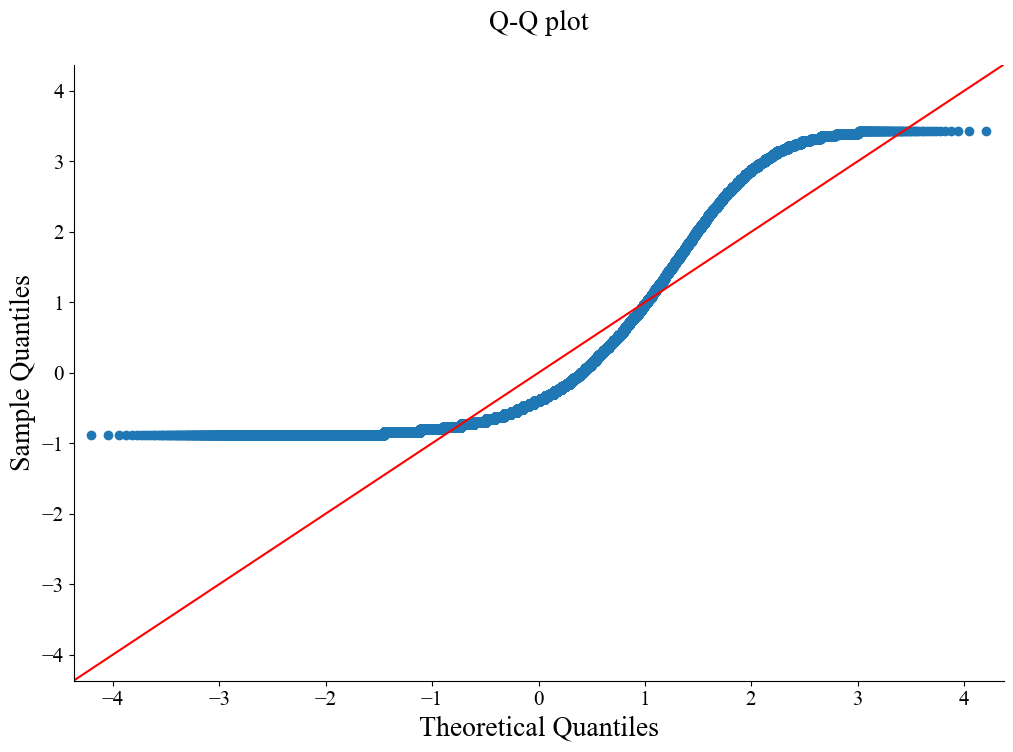

Shapiro-Wilk test p-value: 0.0
Sample is not a normal distribution


In [33]:
# Function to check normality (Q-Q plot and Shapiro–Wilk test)
def checkNormality(data):
    f, ax = plt.subplots()
    qqplot(data, line='45', fit=True, ax=ax)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_title('Q-Q plot')
    plt.show()

    p_value = shapiro(data)
    alpha = 0.05
    print(f"Shapiro-Wilk test p-value: {p_value[1]}")
    if p_value[1] > alpha:
        print('Sample is a normal distribution')
    else:
        print('Sample is not a normal distribution')


checkNormality(dataset['sum_gamerounds'])

#### 1.2.3 Mann-Whitney U test 

Since `sum_gamerounds` is continuous and not normally distributed, we'll use the Mann-Whitney U test.

In [34]:
def mannwhitneyfunc(control,treatment):
    
    stat, p=mannwhitneyu(control, treatment)
    alpha=0.05 
    print('p-value =%.4f'%(p))

    if p > alpha:
        print('Two groups have no significant difference')
    else:
        print('Two groups have a significant difference')

In [35]:
group_A=dataset[dataset['group']=='A']['sum_gamerounds']
group_B=dataset[dataset['group']=='B']['sum_gamerounds']
mannwhitneyfunc(group_A,group_B)

p-value =0.0930
Two groups have no significant difference


Based on the Mann-Whitney U test results, there is **no sufficient evidence** to conclude that the gate placement (gate_30 vs. gate_40) has any significant impact on the distribution of game rounds played within the first 14 days.






#### **Conclusions**:

Based on the results for all three metrics, while **no significant difference** was found in **1-day retention**, the analysis revealed a **statistically significant** decrease **in 7-day retention** and a slight but **statistically insignificant** decrease in the number of **game rounds played** in the group with the gate at level 40. These findings suggest that moving the gate to level 40 may have a negative impact on player engagement.

**Recommendation**:

Based on the A/B test results, maintaining the current gate placement at level 30 is recommended.
